# Canny

In this notebook, we will manually implement the Canny edge detection algorithm.

As a reminder, the steps of this algorithm are:

* Noise reduction using a Gaussian filter
* Gradient calculation (same process as in Sobel)
* Non-maximum suppression to reduce edge thickness to 1 pixel
* Double thresholding and hysteresis

## Noise Reduction

We will use a Gaussian filter with the `cv2.GaussianBlur` function, experimenting with the kernel size and the Sigma value. For example, I will use a 7x7 kernel and a σ of 1.5.

**Note:** Use your previously implemented code to apply the blur.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.image import imsave
import cv2
import numpy as np
import os

def apply_convolution(img, kernel):
    """
    Applies a convolution operation on the input image using the provided kernel.
    """
    # Extract the number of rows and columns from the kernel
    # m = rows
    # n = columns
    rows, cols = kernel.shape
    img_height, img_width = img.shape

    # Adjust dimensions to handle the edges of the image
    img_height = img_height - rows + 1
    img_width = img_width - cols + 1

    # Initialize a new image to store the convolution result
    new_image = np.zeros((img_height, img_width))

    # Perform the cross-correlation operation: G = H * F
    for i in range(img_height):
        for j in range(img_width):
            new_image[i][j] = np.sum(img[i:i+rows, j:j+cols] * kernel)

    return new_image

# Define the blur and Gaussian kernels created in class
blur = np.ones((5, 5), dtype="float") / 25
gaussian = np.array((
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]), dtype="int")

def gaussian_blur(img):
    """
    Applies Gaussian blur using the predefined blur kernel.
    """
    return apply_convolution(img, blur)


## Gradient

The next step is to calculate the direction and magnitude of the gradient vector at each pixel. We previously did this using the Gx and Gy kernels.

**Note:** Replace this with your code.

In [2]:
horizontal = np.array((
	[1, 2, 1],
	[0, 0, 0],
	[-1, -2, -1]), dtype="int")

vertical = np.array((
	[1, 0, -1],
	[2, 0, -2],
	[1, 0, -1]), dtype="int")

def gradients(img):
 
  horizontal_photo=apply_convolution(img,horizontal)
  vertical_photo=apply_convolution(img,vertical)

  imgy, imgx = horizontal_photo.shape
  img = np.zeros((imgy,imgx))

  img = np.hypot(horizontal_photo, vertical_photo)
  img = (img /img.max() * 255).astype(int)

  angles = np.degrees(np.arctan2(vertical_photo,horizontal_photo))
  return img, angles


## Non-Maximum Suppression

It eliminates duplications, reducing the thickness of the edges to a minimum. If a pixel has a neighbor with a higher magnitude, it is removed.

This step aims at reducing the duplicate merging pixels along the edges to make them uneven. For each pixel, find two neighbors in the positive and negative gradient directions, assuming that each neighbor occupies an angle of pi /4, with 0 being the direction straight to the right. If the magnitude of the current pixel is greater than the magnitude of the neighbors, nothing changes; otherwise, the magnitude of the current pixel is set to zero.


In [3]:
def supresion(magnitudes, angles):
  # Copy the input image to remove non-maximum pixels
  res = magnitudes.copy()
  # Iterate through the entire image to suppress non-maximum pixels
  for x in range(res.shape[1]): 
    for y in range(res.shape[0]): 
      # Normalize the angles between 0 and 180
      angle = abs(angles[y, x]-180) if abs(angles[y, x])>180 else abs(angles[y, x]) 
      
      # Depending on the gradient direction, check the neighbors
      if 22.5 < angle <= 67.5: 
        # Top-right
        vec1 = x-1, y-1
        vec2 = x + 1, y + 1
      elif 67.5 < angle <= 112.5:
        # Vertical
        vec1 = x, y-1
        vec2 = x, y + 1
      elif 112.5 < angle <= 157.5:
        # Top-left
        vec1 = x-1, y + 1
        vec2 = x + 1, y-1
      else:
        # Horizontal
        vec1 = x-1, y 
        vec2 = x + 1, y 
      
      # Remove if the value is not a local maximum, being careful not to go out of bounds
      if 0 <= vec1[0] < res.shape[1] and  0 <= vec1[1] < res.shape[0]:
        if magnitudes[y, x] < magnitudes[vec1[1], vec1[0]]: 
          res[y, x] = 0
      if 0 <= vec2[0] < res.shape[1] and  0 <= vec2[1] < res.shape[0]:
        if magnitudes[y, x] < magnitudes[vec2[1], vec2[0]]: 
          res[y, x] = 0
  return res


## Threshold Hysteresis

Now, we filter the edges by removing false positives based on two thresholds: l and h

* We will consider all edges with a value greater than h as valid
* We will consider all edges with a value lower than l as invalid
* For edges with values between l and h, we will consider them valid if they are connected to an edge that exceeds the h threshold


In [4]:
def histeresis(img, l, h):
  res = np.zeros_like(img)

  for x in range(0,img.shape[1]): 
    for y in range(0,img.shape[0]): 
      if img[y, x] < l: 
        res[y, x]= 0

      elif l <= img[y, x] < h:
        res[y,x] = 0

        for i in range(-1,2):
          for j in range(-1,2):
            if x+j >= 0 and y+i >= 0 and x+j < img.shape[1] and y+i < img.shape[0]:
              if img[y+i,x+j] > h: 
                res[y,x] = 255

      else:
        res[y, x]= 255

  return res

In [5]:
# This is an auxiliar function to plot images
def plot_multiple_images(imgs, size=(28, 18), cols=4, cmap='None'):
  plt.figure(figsize=size)
  count = len(imgs)
  rows = count // cols

  for index, img in enumerate(imgs):
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=cmap)
  plt.show()

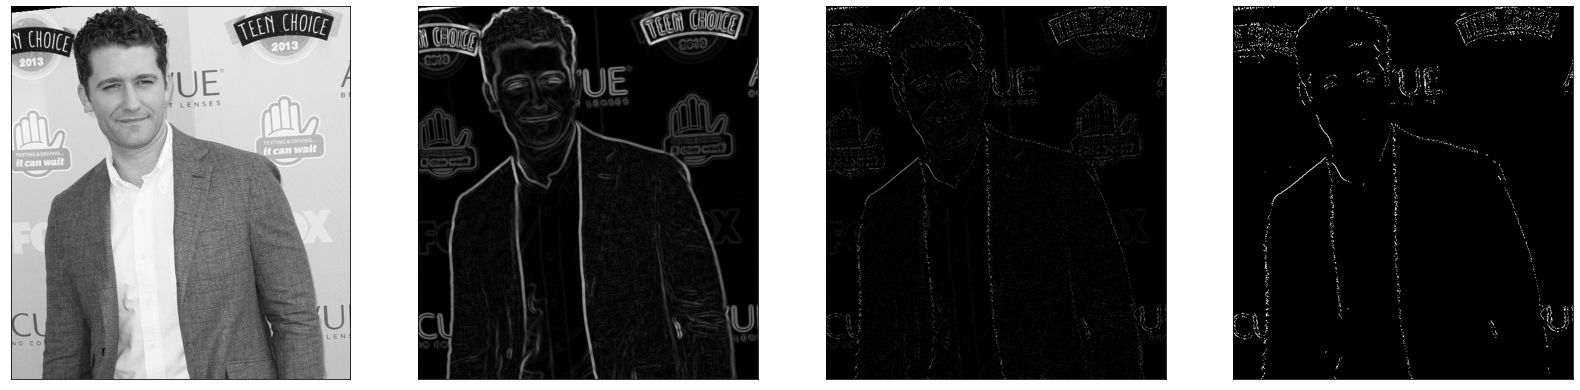

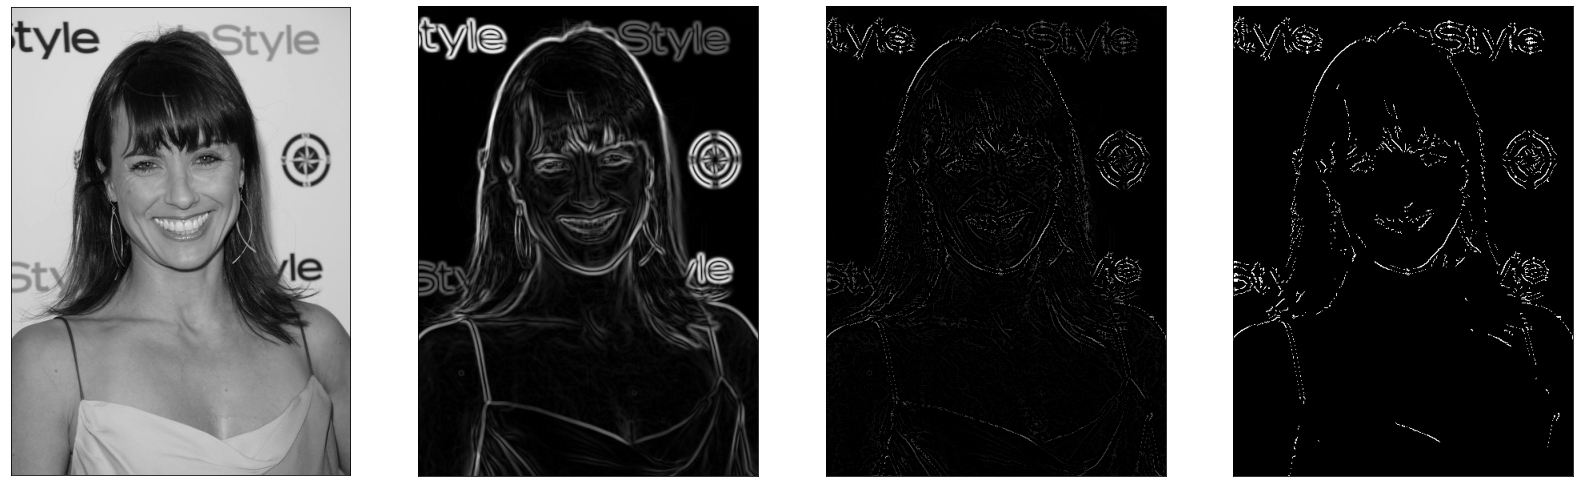

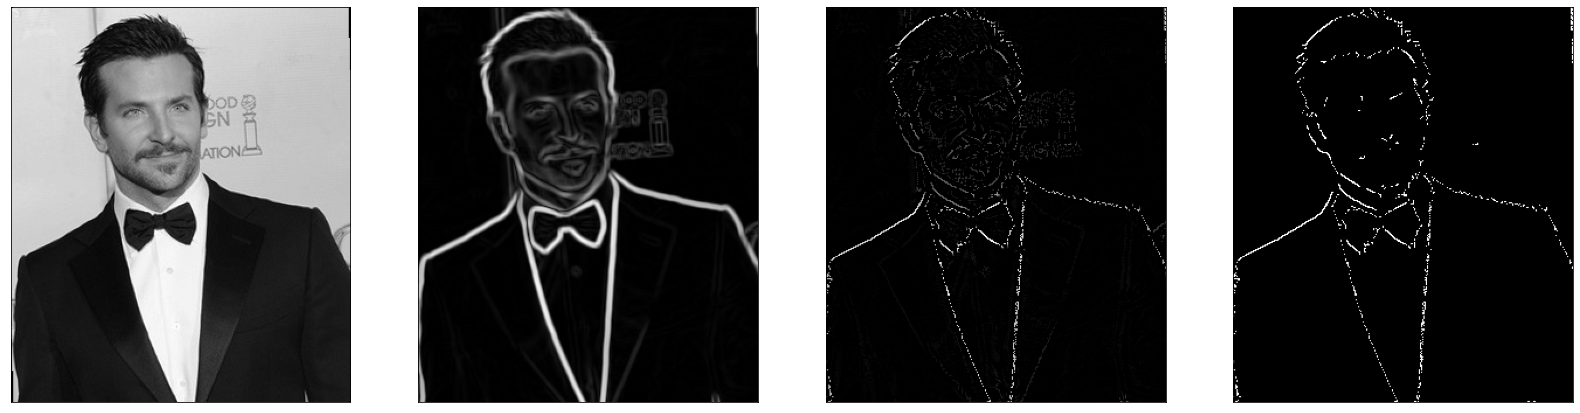

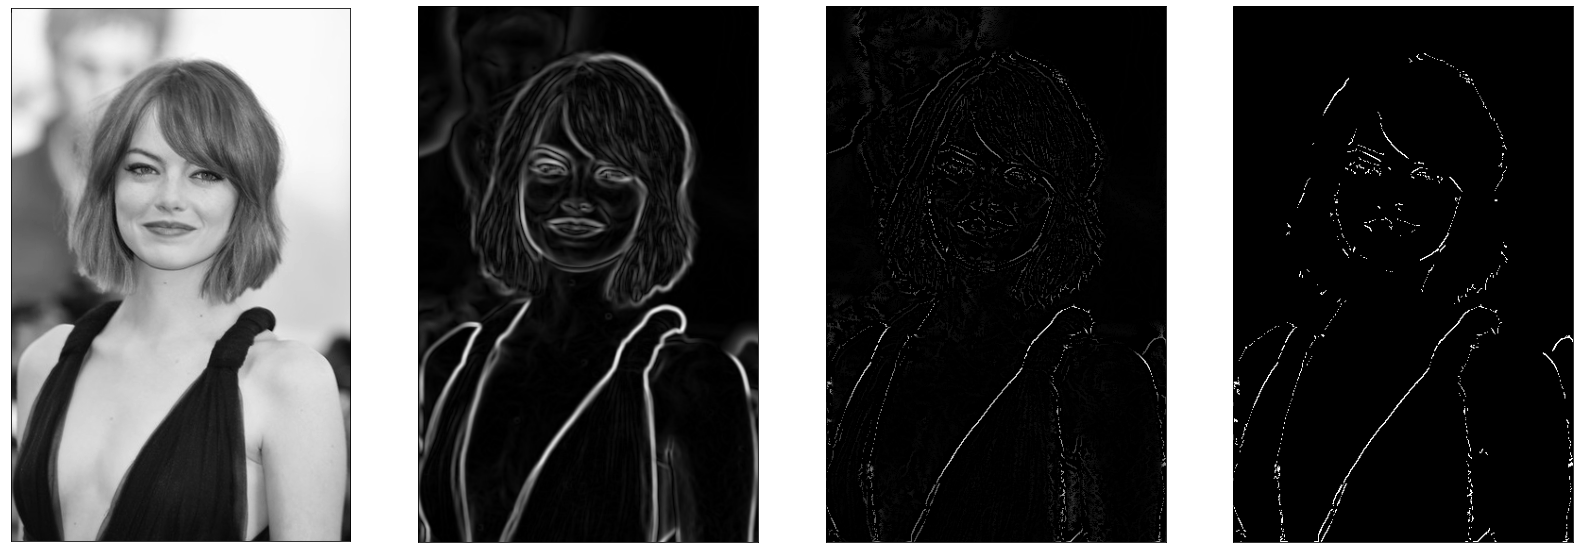

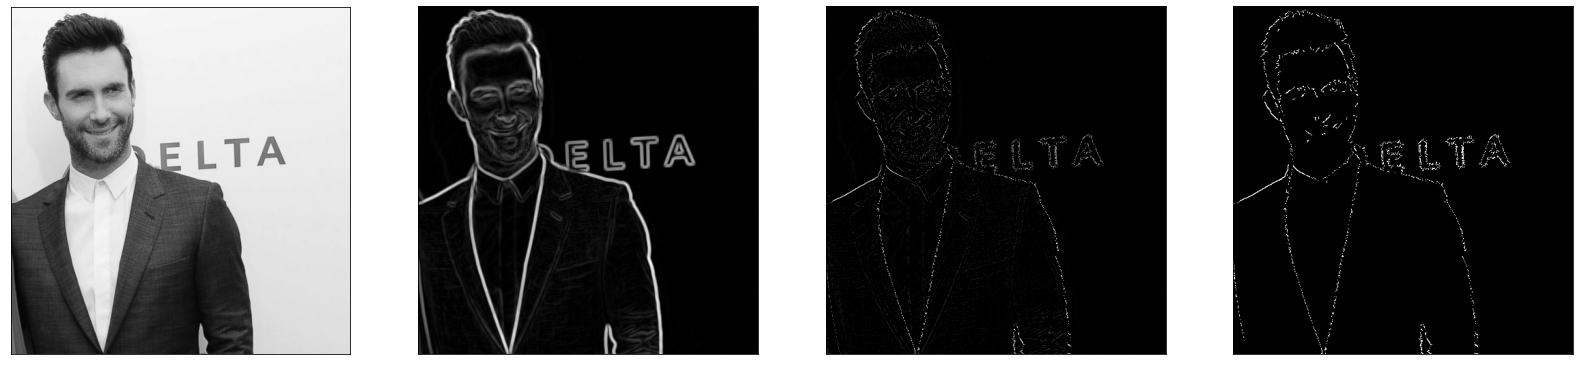

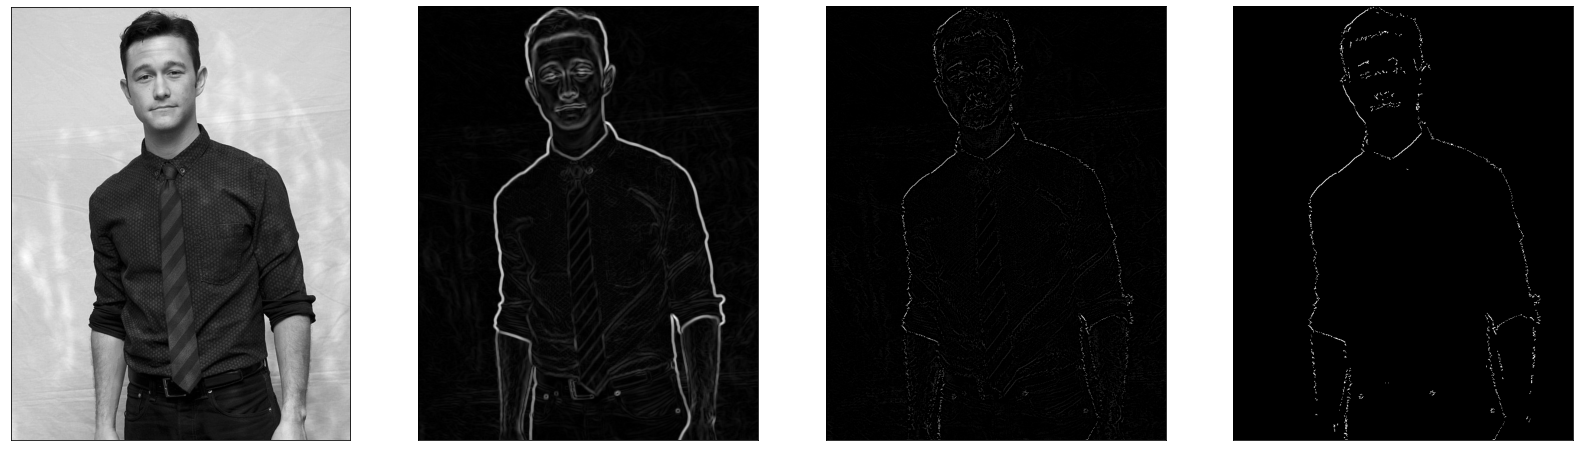

In [8]:
input_folder = 'imgs'
output_folder = 'out'

import os
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

imgs = [cv2.imread(f'{input_folder}/{f}', cv2.IMREAD_GRAYSCALE)for f in os.listdir(input_folder)]

for index, img in enumerate(imgs):
  

  blurred = gaussian_blur(img)
  mag, ang = gradients(blurred)
  supressed = supresion(mag, ang)
  hist = histeresis(supressed, 48, 80)
  plot_multiple_images([img, mag, supressed, hist], cmap='gray')
  imsave(f'{output_folder}/{index}.png', hist, cmap='gray')
